## <center> Packages & Connection </center>

In [1]:
import h3 as h3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from pyhive import presto
from keplergl import KeplerGl
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

## <center> Local extracted files </center>

In [3]:
raw_order_logs_snapshot = pd.read_csv('/Users/rapido/local-datasets/affluence/raw/raw_order_logs_snapshot_10to16.csv')
raw_order_logs_immutable = pd.read_csv('/Users/rapido/local-datasets/affluence/raw//raw_order_logs_immutable_10to16.csv')
raw_fare_estimates_enriched = pd.read_csv('/Users/rapido/local-datasets/affluence/raw//raw_fare_estimates_enriched_10to16.csv')
raw_iallocator_customer_segments = pd.read_csv('/Users/rapido/local-datasets/affluence/raw//raw_iallocator_customer_segments_10to16.csv')

In [4]:
df_oli_main_data = raw_order_logs_immutable.copy(deep=True)
print(df_oli_main_data.shape)

df_ols_main_data = raw_order_logs_snapshot.copy(deep=True)
print(df_ols_main_data.shape)

df_fee_main_data = raw_fare_estimates_enriched.copy(deep=True)
print(df_fee_main_data.shape)

df_segment_main_data = raw_iallocator_customer_segments.copy(deep=True)
print(df_segment_main_data.shape)

(3536034, 16)
(1149637, 12)
(15117222, 17)
(14739326, 15)


In [5]:
df_fee_main_data.head(2)

,yyyymmdd,city,service_name,quarter_hour,time_bucket,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,customer_id,fare_estimate_id,surge_strategy,surge_percentage,dynamic_surge,dynamic_fare,sub_total,discount_amount
0,20230710,Bangalore,Auto,2015,Evening_Peak,Bellandur,8861892569fffff,Varthur,88618920ebfffff,5e591dcc1275a31e1e5833c9,64ac1af42a70c7ac0b2b56f8,surge_dashboard_rule,10.204082,0.00,10.0,108.0,0.0
1,20230710,Bangalore,Link,1800,Evening_Peak,Basavanagudi,8861892597fffff,Cambridge Layout Ulsoor,8861892ed1fffff,62c843ef0eef7f6e35f11140,64abfc344f76e21a1142b7dc,rain,39.517694,42.77,0.0,151.0,10.0


In [6]:
df_ols_main_data.head(2)

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,estimate_id,order_id,geo_distance,discount,sub_total
0,20230713,Bangalore,Link,Ramaiah College,8860145941fffff,Metro - Sandal Soap Factory,8860145b37fffff,64aff1369c5b35742a429410,64afee9fb82ebd52fc9898da,0.086537,14.0,67.0
1,20230713,Bangalore,Auto,RTO HSR Sec 1,8861892553fffff,Kudlu Gate,886189246bfffff,64aff32f918567f17f3cfa3c,64aff3345332de3f2f5b9e0f,0.013049,0.0,79.0


In [7]:
df_oli_main_data.head(2)

,yyyymmdd,city,service_name,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,estimate_id,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders
0,20230710,Bangalore,Link,HSR Sec 2,886189242dfffff,BTM,88618925ddfffff,64ac0b367912742548bb4557,1,1,0,1,0,0,0,0
1,20230710,Bangalore,Auto,Electronic City,8861892663fffff,Electronic City Phase 2,8861892665fffff,64ac094676627a108e685bd2,1,1,0,0,1,0,0,0


In [8]:
df_segment_main_data.head(2)

,yyyymmdd,customer_id,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,fe_intent_stable,fe_intent_increasing,fe_intent_declining
0,20230710,5737c6baddbec2203f7331d9,NaN,NaN,NaN,NaN,NaN,5737c6baddbec2203f7331d9,NaN,5737c6baddbec2203f7331d9,5737c6baddbec2203f7331d9,NaN,5737c6baddbec2203f7331d9,NaN,NaN
1,20230710,5737c6c1ddbec2203f73321e,NaN,5737c6c1ddbec2203f73321e,NaN,5737c6c1ddbec2203f73321e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5737c6c1ddbec2203f73321e


##

In [9]:
## fee & oli

df_fe_rr_data = pd.merge(df_fee_main_data[df_fee_main_data['service_name'].isin(['Link'])], \
                             df_oli_main_data[df_oli_main_data['service_name'].isin(['Link'])], \
                             how='left', \
                             left_on = ['yyyymmdd', 'city', 'service_name', 'fare_estimate_id', \
                                        'pickup_cluster', 'pickup_hex_8', 'drop_cluster', 'drop_hex_8'], \
                             right_on = ['yyyymmdd', 'city', 'service_name', 'estimate_id', \
                                         'pickup_cluster', 'pickup_hex_8', 'drop_cluster', 'drop_hex_8'], \
                            )

In [10]:
df_fe_rr_data[df_fe_rr_data['fare_estimate_id'].isin(['64ace765126ec564e4a789ef','64b201d727b0e89d3cda1123'])]

,yyyymmdd,city,service_name,quarter_hour,time_bucket,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,customer_id,fare_estimate_id,surge_strategy,surge_percentage,dynamic_surge,dynamic_fare,sub_total,discount_amount,estimate_id,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders
1992315,20230711,Bangalore,Link,1045,Morning_Peak,Columbia Asia Whitefield,88618920e7fffff,Whitefield,88618921d3fffff,5fb36b6d7a3a3547d26d5744,64ace765126ec564e4a789ef,mismatch_gradient,21.951220,9.00,0.0,50.0,0.0,64ace765126ec564e4a789ef,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6046494,20230715,Bangalore,Link,745,Rest_Morning,Varthur,88618920c1fffff,Kadubeesanahalli,8861892095fffff,625125b349bc1231f17f0c33,64b201d727b0e89d3cda1123,hot_cold_surge,36.843671,24.77,0.0,92.0,0.0,64b201d727b0e89d3cda1123,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [11]:
## fe_rr & ols

df_fe_net_data = pd.merge(df_fe_rr_data, \
                             df_ols_main_data[df_ols_main_data['service_name'].isin(['Link'])], \
                             how='left', \
                             left_on = ['yyyymmdd', 'city', 'service_name', 'fare_estimate_id', \
                                        'pickup_cluster', 'pickup_hex_8', 'drop_cluster', 'drop_hex_8'], \
                             right_on = ['yyyymmdd', 'city', 'service_name', 'estimate_id', \
                                         'pickup_cluster', 'pickup_hex_8', 'drop_cluster', 'drop_hex_8'], \
                            )

In [12]:
df_fe_net_data[df_fe_net_data['fare_estimate_id'].isin(['64ace765126ec564e4a789ef','64b201d727b0e89d3cda1123'])]

,yyyymmdd,city,service_name,quarter_hour,time_bucket,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,customer_id,fare_estimate_id,surge_strategy,surge_percentage,dynamic_surge,dynamic_fare,sub_total_x,discount_amount,estimate_id_x,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders,estimate_id_y,order_id,geo_distance,discount,sub_total_y
1992315,20230711,Bangalore,Link,1045,Morning_Peak,Columbia Asia Whitefield,88618920e7fffff,Whitefield,88618921d3fffff,5fb36b6d7a3a3547d26d5744,64ace765126ec564e4a789ef,mismatch_gradient,21.951220,9.00,0.0,50.0,0.0,64ace765126ec564e4a789ef,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,64ace765126ec564e4a789ef,64ace77f1730d6386185c385,0.028955,0.0,50.0
6046494,20230715,Bangalore,Link,745,Rest_Morning,Varthur,88618920c1fffff,Kadubeesanahalli,8861892095fffff,625125b349bc1231f17f0c33,64b201d727b0e89d3cda1123,hot_cold_surge,36.843671,24.77,0.0,92.0,0.0,64b201d727b0e89d3cda1123,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,64b201d727b0e89d3cda1123,64b1fcea9b33b462d628d5a8,0.031512,0.0,92.0


In [13]:
df_all_raw_data = pd.merge(df_fe_net_data, \
                           df_segment_main_data[['yyyymmdd', 'customer_id', \
                                                 'taxi_high_income', 'taxi_medium_income', \
                                                 'taxi_low_income', 'link_only_service', 'auto_only_service', \
                                                 'both_service', 'link_ps', 'link_nps', 'auto_ps', 'auto_nps']], \
                           how='left', \
                           left_on = ['yyyymmdd', 'customer_id'], \
                           right_on = ['yyyymmdd', 'customer_id']
                        )

In [14]:
df_all_raw_data[df_all_raw_data['fare_estimate_id'].isin(['64ace765126ec564e4a789ef','64b201d727b0e89d3cda1123'])]

,yyyymmdd,city,service_name,quarter_hour,time_bucket,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,customer_id,fare_estimate_id,surge_strategy,surge_percentage,dynamic_surge,dynamic_fare,sub_total_x,discount_amount,estimate_id_x,gross_orders,requested_orders,cobrm,expiry_mapped,cobra,accepted_orders,ocara,net_orders,estimate_id_y,order_id,geo_distance,discount,sub_total_y,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps
1992315,20230711,Bangalore,Link,1045,Morning_Peak,Columbia Asia Whitefield,88618920e7fffff,Whitefield,88618921d3fffff,5fb36b6d7a3a3547d26d5744,64ace765126ec564e4a789ef,mismatch_gradient,21.951220,9.00,0.0,50.0,0.0,64ace765126ec564e4a789ef,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,64ace765126ec564e4a789ef,64ace77f1730d6386185c385,0.028955,0.0,50.0,5fb36b6d7a3a3547d26d5744,NaN,NaN,NaN,NaN,5fb36b6d7a3a3547d26d5744,5fb36b6d7a3a3547d26d5744,NaN,NaN,NaN
6046494,20230715,Bangalore,Link,745,Rest_Morning,Varthur,88618920c1fffff,Kadubeesanahalli,8861892095fffff,625125b349bc1231f17f0c33,64b201d727b0e89d3cda1123,hot_cold_surge,36.843671,24.77,0.0,92.0,0.0,64b201d727b0e89d3cda1123,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,64b201d727b0e89d3cda1123,64b1fcea9b33b462d628d5a8,0.031512,0.0,92.0,625125b349bc1231f17f0c33,NaN,NaN,NaN,NaN,625125b349bc1231f17f0c33,625125b349bc1231f17f0c33,NaN,NaN,625125b349bc1231f17f0c33


## Processing

In [15]:
df_all_raw_data['surge_strategy'].unique()

array(['rain', 'no_surge', 'hot_cold_surge', 'mismatch_generic',
       'mismatch_gradient', 'surge_dashboard_rule', 'circuit_broken'],
      dtype=object)

In [16]:
# New columns

df_all_raw_data['surge_strategy_applied'] = np.where( \
                                                     df_all_raw_data['surge_strategy'] \
                                                     .isin(['rain', 'mismatch_generic', 'hot_cold_surge', \
                                                            'mismatch_gradient', 'circuit_broken', \
                                                            'surge_dashboard_rule']),    
                                                     df_all_raw_data['fare_estimate_id'],
                                                     None)
df_all_raw_data['discount_applied'] = np.where( \
                                                     df_all_raw_data['discount'] > 0,    
                                                     df_all_raw_data['order_id'],
                                                     None)
df_all_raw_data['geo_distance_1'] = df_all_raw_data['geo_distance']
df_all_raw_data['sub_total_surged_fe'] = np.where( \
                                                    (df_all_raw_data['dynamic_surge'] > 0),    
                                                     df_all_raw_data['sub_total_x'],
                                                     None)

In [17]:
df_all_raw_data.columns

Index(['yyyymmdd', 'city', 'service_name', 'quarter_hour', 'time_bucket',
       'pickup_cluster', 'pickup_hex_8', 'drop_cluster', 'drop_hex_8',
       'customer_id', 'fare_estimate_id', 'surge_strategy', 'surge_percentage',
       'dynamic_surge', 'dynamic_fare', 'sub_total_x', 'discount_amount',
       'estimate_id_x', 'gross_orders', 'requested_orders', 'cobrm',
       'expiry_mapped', 'cobra', 'accepted_orders', 'ocara', 'net_orders',
       'estimate_id_y', 'order_id', 'geo_distance', 'discount', 'sub_total_y',
       'taxi_high_income', 'taxi_medium_income', 'taxi_low_income',
       'link_only_service', 'auto_only_service', 'both_service', 'link_ps',
       'link_nps', 'auto_ps', 'auto_nps', 'surge_strategy_applied',
       'discount_applied', 'geo_distance_1', 'sub_total_surged_fe'],
      dtype='object')

In [18]:
df_refined_data =  df_all_raw_data.groupby(['pickup_cluster', 'pickup_hex_8']) \
                                    .agg({'fare_estimate_id' : 'nunique', \
                                          'gross_orders' : 'sum', \
                                          'order_id' : 'nunique', \
                                          'dynamic_surge' : 'sum', 'dynamic_fare' : 'sum', \
                                          'sub_total_x' : 'sum', 'sub_total_surged_fe' : 'sum',
                                          'surge_strategy_applied' : 'nunique', \
                                          #'dynamic_surge' : 'sum',  \ 
                                          #'dynamic_fare' : 'sum', \ 
                                          #'sub_total_x' : 'sum', \     
                                          'discount_applied' : 'nunique', \
                                          'surge_percentage' : 'mean', \
                                          'discount_amount' : 'sum', \
                                          'discount' : 'sum', \
                                          #'sub_total' : 'sum', \
                                          'customer_id' : 'nunique', \
                                          'taxi_high_income' : 'nunique', \
                                          'taxi_medium_income' : 'nunique', \
                                          'taxi_low_income' : 'nunique', \
                                          'link_only_service' : 'nunique', \
                                          'auto_only_service' : 'nunique', \
                                          'both_service' : 'nunique', \
                                          'link_ps' : 'nunique', \
                                          'link_nps' : 'nunique', \
                                          'auto_ps' : 'nunique', \
                                          'auto_nps' : 'nunique', \
                                          'geo_distance' : 'mean', \
                                          'geo_distance_1' : 'max' \
                                          }).reset_index()
df_refined_data.head(5)
#df_refined_data.columns = df_refined_data.columns.droplevel(1)
df_refined_data.rename(columns = {'fare_estimate_id' : 'fe_count', \
                                  'order_id' : 'net_orders', \
                                  'sub_total_x' : 'sub_total', \
                                  'surge_strategy_applied' : 'surged_fe', \
                                  'discount_applied' : 'discounted_order', \
                                  'customer_id' : 'fe_customer_count', \
                                  'geo_distance' : 'mean_geo_distance', \
                                  'geo_distance_1' : 'max_geo_distance' \
                                 }, inplace = True)

In [19]:
df_refined_data

,pickup_cluster,pickup_hex_8,fe_count,gross_orders,net_orders,dynamic_surge,dynamic_fare,sub_total,sub_total_surged_fe,surged_fe,discounted_order,surge_percentage,discount_amount,discount,fe_customer_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,mean_geo_distance,max_geo_distance
0,AECS Layout Brookefield,88618920a3fffff,40894,8813.0,3768,449312.72,0.0,4357200.0,1971694.0,17523,1582,12.170825,84312.0,23915.0,10354,4738,2414,337,978,1149,7030,1477,2674,2345,3891,0.026200,0.537243
1,Adugodi,8861892581fffff,16022,2681.0,935,106256.06,0.0,1493413.0,488792.0,4570,406,6.861859,35835.0,6462.0,3934,1624,1043,195,330,601,2505,527,921,972,1457,0.026975,0.674754
2,Adugodi,886189258bfffff,19192,3313.0,946,153318.85,0.0,1835146.0,678979.0,6057,370,8.507895,46205.0,5559.0,4230,1812,1111,195,333,758,2665,523,1013,1067,1565,0.038462,0.737737
3,Adugodi Traffic Station,886189258dfffff,25303,4166.0,1415,91733.17,0.0,2128804.0,442710.0,4062,252,3.603886,52424.0,2772.0,5771,2450,1559,273,494,807,3854,802,1528,1451,2209,0.032623,0.886427
4,Agara Lake,8861892425fffff,18454,3351.0,1299,138417.52,0.0,1718183.0,641839.0,6368,652,8.968662,37943.0,10093.0,4783,2136,1260,250,325,678,3442,723,1362,1264,1995,0.025169,0.547280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679,Yeshwanthpur,8860145955fffff,2669,367.0,116,18581.04,0.0,354793.0,98519.0,734,60,5.930709,6108.0,982.0,1050,354,274,49,135,139,574,125,199,177,282,0.043321,0.399139
2680,Yeshwanthpur,8860145957fffff,7538,1447.0,531,51193.04,0.0,974479.0,271837.0,2252,308,5.772449,14085.0,5520.0,3033,1077,807,128,463,317,1741,372,640,476,844,0.058569,1.577413
2681,Yeshwanthpur,8860145959fffff,2799,504.0,212,16902.87,0.0,306480.0,83356.0,646,134,4.857940,6721.0,2185.0,904,317,233,61,83,138,551,133,202,177,289,0.030163,0.353574
2682,Yeshwanthpur,886014595bfffff,2514,459.0,207,13643.83,0.0,287404.0,72637.0,687,125,5.160681,5860.0,2102.0,857,295,243,55,90,153,479,108,184,145,273,0.027885,0.383501


In [20]:
## percentage column

df_refined_data['high_income_cp']=round(df_refined_data['taxi_high_income']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['medium_income_cp']=round(df_refined_data['taxi_medium_income']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['low_income_cp']=round(df_refined_data['taxi_low_income']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['link_only_cp']=round(df_refined_data['link_only_service']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['auto_only_cp']=round(df_refined_data['auto_only_service']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['both_service_cp']=round(df_refined_data['both_service']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['link_ps_cp']=round(df_refined_data['link_ps']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['link_nps_cp']=round(df_refined_data['link_nps']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['auto_ps_cp']=round(df_refined_data['auto_ps']*100/df_refined_data['fe_customer_count'] \
                                          , 2)
df_refined_data['auto_nps_cp']=round(df_refined_data['auto_nps']*100/df_refined_data['fe_customer_count'] \
                                          , 2)

In [21]:
df_refined_data

,pickup_cluster,pickup_hex_8,fe_count,gross_orders,net_orders,dynamic_surge,dynamic_fare,sub_total,sub_total_surged_fe,surged_fe,discounted_order,surge_percentage,discount_amount,discount,fe_customer_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,mean_geo_distance,max_geo_distance,high_income_cp,medium_income_cp,low_income_cp,link_only_cp,auto_only_cp,both_service_cp,link_ps_cp,link_nps_cp,auto_ps_cp,auto_nps_cp
0,AECS Layout Brookefield,88618920a3fffff,40894,8813.0,3768,449312.72,0.0,4357200.0,1971694.0,17523,1582,12.170825,84312.0,23915.0,10354,4738,2414,337,978,1149,7030,1477,2674,2345,3891,0.026200,0.537243,45.76,23.31,3.25,9.45,11.10,67.90,14.27,25.83,22.65,37.58
1,Adugodi,8861892581fffff,16022,2681.0,935,106256.06,0.0,1493413.0,488792.0,4570,406,6.861859,35835.0,6462.0,3934,1624,1043,195,330,601,2505,527,921,972,1457,0.026975,0.674754,41.28,26.51,4.96,8.39,15.28,63.68,13.40,23.41,24.71,37.04
2,Adugodi,886189258bfffff,19192,3313.0,946,153318.85,0.0,1835146.0,678979.0,6057,370,8.507895,46205.0,5559.0,4230,1812,1111,195,333,758,2665,523,1013,1067,1565,0.038462,0.737737,42.84,26.26,4.61,7.87,17.92,63.00,12.36,23.95,25.22,37.00
3,Adugodi Traffic Station,886189258dfffff,25303,4166.0,1415,91733.17,0.0,2128804.0,442710.0,4062,252,3.603886,52424.0,2772.0,5771,2450,1559,273,494,807,3854,802,1528,1451,2209,0.032623,0.886427,42.45,27.01,4.73,8.56,13.98,66.78,13.90,26.48,25.14,38.28
4,Agara Lake,8861892425fffff,18454,3351.0,1299,138417.52,0.0,1718183.0,641839.0,6368,652,8.968662,37943.0,10093.0,4783,2136,1260,250,325,678,3442,723,1362,1264,1995,0.025169,0.547280,44.66,26.34,5.23,6.79,14.18,71.96,15.12,28.48,26.43,41.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679,Yeshwanthpur,8860145955fffff,2669,367.0,116,18581.04,0.0,354793.0,98519.0,734,60,5.930709,6108.0,982.0,1050,354,274,49,135,139,574,125,199,177,282,0.043321,0.399139,33.71,26.10,4.67,12.86,13.24,54.67,11.90,18.95,16.86,26.86
2680,Yeshwanthpur,8860145957fffff,7538,1447.0,531,51193.04,0.0,974479.0,271837.0,2252,308,5.772449,14085.0,5520.0,3033,1077,807,128,463,317,1741,372,640,476,844,0.058569,1.577413,35.51,26.61,4.22,15.27,10.45,57.40,12.27,21.10,15.69,27.83
2681,Yeshwanthpur,8860145959fffff,2799,504.0,212,16902.87,0.0,306480.0,83356.0,646,134,4.857940,6721.0,2185.0,904,317,233,61,83,138,551,133,202,177,289,0.030163,0.353574,35.07,25.77,6.75,9.18,15.27,60.95,14.71,22.35,19.58,31.97
2682,Yeshwanthpur,886014595bfffff,2514,459.0,207,13643.83,0.0,287404.0,72637.0,687,125,5.160681,5860.0,2102.0,857,295,243,55,90,153,479,108,184,145,273,0.027885,0.383501,34.42,28.35,6.42,10.50,17.85,55.89,12.60,21.47,16.92,31.86


In [22]:
df_refined_data.high_income_cp.describe()

count    2684.000000
mean       27.623983
std        19.906558
min         0.000000
25%        14.290000
50%        29.755000
75%        37.407500
max       100.000000
Name: high_income_cp, dtype: float64

<Axes: ylabel='Density'>

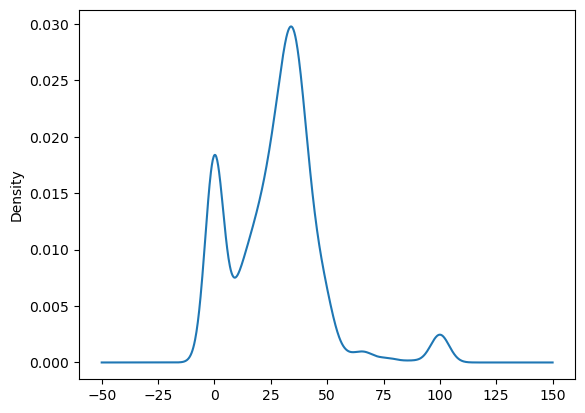

In [23]:
df_refined_data.high_income_cp.plot( kind = 'kde')

In [24]:
df_refined_data.fe_count.describe()

count      2684.000000
mean       2808.157973
std        7271.901545
min           1.000000
25%          14.000000
50%         118.000000
75%        2015.500000
max      100666.000000
Name: fe_count, dtype: float64

In [25]:
df_refined_data.fe_count.quantile(0.80)

3176.600000000001

In [26]:
df_refined_data.mean_geo_distance.describe()

count    1608.000000
mean        0.043451
std         0.038841
min         0.000089
25%         0.026495
50%         0.034103
75%         0.047249
max         0.567303
Name: mean_geo_distance, dtype: float64

In [27]:
df_refined_data.max_geo_distance.describe()

count    1608.000000
mean        0.585381
std         8.929464
min         0.000089
25%         0.131734
50%         0.315236
75%         0.505349
max       357.613107
Name: max_geo_distance, dtype: float64

In [28]:
df_refined_data['pickup_cluster'].unique()

array(['AECS Layout Brookefield', 'Adugodi', 'Adugodi Traffic Station',
       'Agara Lake', 'Akshaynagar', 'Akshaynagar Lake', 'Anepalya',
       'Anjanapura', 'Arekere', 'Arekere Extension', 'Arekere Lake',
       'Arekere Mico Layout', 'Attibele', 'BEL Layout', 'BGS Kengeri',
       'BLR_Ashok Nagar', 'BLR_HRBR Layout', 'BLR_Hoskote',
       'BLR_Indiranagar', 'BTM', 'BTM 2nd Stage', 'BTM Second Stage',
       'Bagalur', 'Baiyappanahalli - CV Raman Nagar',
       'Baiyyappanahalli Cabin', 'Balagere', 'Banashankri',
       'Banashankri North', 'Banashankri South', 'Banashankri West',
       'Banaswadi', 'Banaswadi Railway Station', 'Bangalore Airport',
       'Bannerghatta', 'Bannerghatta Road - Hulimavu', 'Bannerghatta Zoo',
       'Basavanagudi', 'Basaveshwar Nagar', 'Begur', 'Begur Fort',
       'Begur Lake', 'Bellandur', 'Bidadi', 'Bilekahalli IIM',
       'Bommanahali', 'Bommasandra Industrial Area', 'Brookefield',
       'C V Raman Nagar', 'CPWD Qtrs HSR ', 'Cambridge College',

In [29]:
df_refined_data[df_refined_data['pickup_cluster'].isin(['Metro - Yeshwantpur', 'Hsr'])]

,pickup_cluster,pickup_hex_8,fe_count,gross_orders,net_orders,dynamic_surge,dynamic_fare,sub_total,sub_total_surged_fe,surged_fe,discounted_order,surge_percentage,discount_amount,discount,fe_customer_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,mean_geo_distance,max_geo_distance,high_income_cp,medium_income_cp,low_income_cp,link_only_cp,auto_only_cp,both_service_cp,link_ps_cp,link_nps_cp,auto_ps_cp,auto_nps_cp
1411,Hsr,8861892421fffff,52691,7115.0,2717,832053.72,0.0,5447654.0,3537267.0,32811,1702,19.044667,106848.0,29282.0,12707,6057,3023,559,586,1948,9251,1686,3531,3553,5315,0.022057,0.705194,47.67,23.79,4.40,4.61,15.33,72.80,13.27,27.79,27.96,41.83
1412,Hsr,8861892423fffff,39107,7161.0,2722,523696.85,0.0,4079833.0,2288890.0,20875,1618,15.531325,69712.0,26563.0,10012,4009,2846,539,870,1076,7036,1489,2829,2358,3686,0.026328,0.607425,40.04,28.43,5.38,8.69,10.75,70.28,14.87,28.26,23.55,36.82
1732,Metro - Yeshwantpur,886014595dfffff,20950,2710.0,888,112962.06,0.0,3238679.0,576296.0,3938,335,3.586439,53080.0,5059.0,7964,2391,1979,337,938,801,4114,842,1254,1091,1830,0.092334,0.712733,30.02,24.85,4.23,11.78,10.06,51.66,10.57,15.75,13.70,22.98


In [30]:
# Signal 1
df_refined_data['income_signal'] = np.where(df_refined_data['high_income_cp'] > 32, 'High Income', 'Low Income')

# Signal 2
df_refined_data['density_signal'] = np.where(df_refined_data['fe_count'] > 3177, 'High FE', 'Low FE')

# Signal 3
## mean distance (q75) and max distance (q50)
df_refined_data['pickup_signal'] = np.where(df_refined_data['max_geo_distance'] > 0.31 , \
                                            'High Distance', 'Low Distance')

In [31]:
df_refined_data

,pickup_cluster,pickup_hex_8,fe_count,gross_orders,net_orders,dynamic_surge,dynamic_fare,sub_total,sub_total_surged_fe,surged_fe,discounted_order,surge_percentage,discount_amount,discount,fe_customer_count,taxi_high_income,taxi_medium_income,taxi_low_income,link_only_service,auto_only_service,both_service,link_ps,link_nps,auto_ps,auto_nps,mean_geo_distance,max_geo_distance,high_income_cp,medium_income_cp,low_income_cp,link_only_cp,auto_only_cp,both_service_cp,link_ps_cp,link_nps_cp,auto_ps_cp,auto_nps_cp,income_signal,density_signal,pickup_signal
0,AECS Layout Brookefield,88618920a3fffff,40894,8813.0,3768,449312.72,0.0,4357200.0,1971694.0,17523,1582,12.170825,84312.0,23915.0,10354,4738,2414,337,978,1149,7030,1477,2674,2345,3891,0.026200,0.537243,45.76,23.31,3.25,9.45,11.10,67.90,14.27,25.83,22.65,37.58,High Income,High FE,High Distance
1,Adugodi,8861892581fffff,16022,2681.0,935,106256.06,0.0,1493413.0,488792.0,4570,406,6.861859,35835.0,6462.0,3934,1624,1043,195,330,601,2505,527,921,972,1457,0.026975,0.674754,41.28,26.51,4.96,8.39,15.28,63.68,13.40,23.41,24.71,37.04,High Income,High FE,High Distance
2,Adugodi,886189258bfffff,19192,3313.0,946,153318.85,0.0,1835146.0,678979.0,6057,370,8.507895,46205.0,5559.0,4230,1812,1111,195,333,758,2665,523,1013,1067,1565,0.038462,0.737737,42.84,26.26,4.61,7.87,17.92,63.00,12.36,23.95,25.22,37.00,High Income,High FE,High Distance
3,Adugodi Traffic Station,886189258dfffff,25303,4166.0,1415,91733.17,0.0,2128804.0,442710.0,4062,252,3.603886,52424.0,2772.0,5771,2450,1559,273,494,807,3854,802,1528,1451,2209,0.032623,0.886427,42.45,27.01,4.73,8.56,13.98,66.78,13.90,26.48,25.14,38.28,High Income,High FE,High Distance
4,Agara Lake,8861892425fffff,18454,3351.0,1299,138417.52,0.0,1718183.0,641839.0,6368,652,8.968662,37943.0,10093.0,4783,2136,1260,250,325,678,3442,723,1362,1264,1995,0.025169,0.547280,44.66,26.34,5.23,6.79,14.18,71.96,15.12,28.48,26.43,41.71,High Income,High FE,High Distance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679,Yeshwanthpur,8860145955fffff,2669,367.0,116,18581.04,0.0,354793.0,98519.0,734,60,5.930709,6108.0,982.0,1050,354,274,49,135,139,574,125,199,177,282,0.043321,0.399139,33.71,26.10,4.67,12.86,13.24,54.67,11.90,18.95,16.86,26.86,High Income,Low FE,High Distance
2680,Yeshwanthpur,8860145957fffff,7538,1447.0,531,51193.04,0.0,974479.0,271837.0,2252,308,5.772449,14085.0,5520.0,3033,1077,807,128,463,317,1741,372,640,476,844,0.058569,1.577413,35.51,26.61,4.22,15.27,10.45,57.40,12.27,21.10,15.69,27.83,High Income,High FE,High Distance
2681,Yeshwanthpur,8860145959fffff,2799,504.0,212,16902.87,0.0,306480.0,83356.0,646,134,4.857940,6721.0,2185.0,904,317,233,61,83,138,551,133,202,177,289,0.030163,0.353574,35.07,25.77,6.75,9.18,15.27,60.95,14.71,22.35,19.58,31.97,High Income,Low FE,High Distance
2682,Yeshwanthpur,886014595bfffff,2514,459.0,207,13643.83,0.0,287404.0,72637.0,687,125,5.160681,5860.0,2102.0,857,295,243,55,90,153,479,108,184,145,273,0.027885,0.383501,34.42,28.35,6.42,10.50,17.85,55.89,12.60,21.47,16.92,31.86,High Income,Low FE,High Distance


In [32]:
df_refined_data['pickup_signal'] = np.where(df_refined_data['max_geo_distance'] > 0.31 , \
                                            'High Distance', 'Low Distance')

In [33]:
df_agg1 =  df_refined_data.groupby(['income_signal', 'density_signal'])\
                            .agg({'pickup_hex_8' : 'count', \
                                   'fe_count' : 'sum', \
                                   'gross_orders' : 'sum', \
                                   'net_orders' : 'sum', 'dynamic_surge' : 'sum', 'dynamic_fare' : 'sum', \
                                   'sub_total_surged_fe' : 'sum', \
                                   'sub_total' : 'sum', \
                                   'surge_percentage' : 'mean', \
                                   'discount' : 'sum', \
                                   #'sub_total' : 'sum', \
                                   'fe_customer_count' : 'sum', \
                                   'surged_fe' : 'sum', \
                                   'discounted_order' : 'sum'
                                  }).reset_index()
df_agg1['hex_distr'] = round(df_agg1['pickup_hex_8']*100.00/df_agg1.pickup_hex_8.sum(), 2)
df_agg1['fe2rr'] = round(df_agg1['gross_orders']*100.00/df_agg1['fe_count'], 2)
df_agg1['fe2net'] = round(df_agg1['net_orders']*100.00/df_agg1['fe_count'], 2)
df_agg1['g2n'] = round(df_agg1['net_orders']*100.00/df_agg1['gross_orders'], 2)
df_agg1['fe/hex'] = round(df_agg1['fe_count']/df_agg1['pickup_hex_8'], 2)
df_agg1['fe/hex'] = round(df_agg1['fe_count']/df_agg1['pickup_hex_8'], 2)
df_agg1['dpr'] = round(df_agg1['discount']/df_agg1['net_orders'], 2)
df_agg1['dpdr'] = round(df_agg1['discount']/df_agg1['discounted_order'], 2)
df_agg1['surged_fe_p'] = round(df_agg1['surged_fe']*100.00/df_agg1['fe_count'], 2)
df_agg1['nume'] = (df_agg1['dynamic_surge'] + df_agg1['dynamic_fare'])
df_agg1['deno'] = df_agg1['sub_total_surged_fe']-(df_agg1['dynamic_surge'] + df_agg1['dynamic_fare'])
#df_agg1['discount_p'] = round(df_agg1['discount']*100.00/df_agg1['sub_total'], 2)
#df_agg1['net/hex'] = df_agg1['net_orders']/df_agg1['pickup_hex_8']

In [34]:
df_agg1['surge_percentage_surged_fe'] = df_agg1['nume']*100.0/df_agg1['deno']
df_agg1 = df_agg1[['income_signal', 'density_signal', 'pickup_hex_8', 'hex_distr', 'fe_count', 'gross_orders', 'net_orders',\
         'fe2rr', 'g2n' ,'fe2net', 'fe/hex', \
         'fe_customer_count', 'surged_fe', 'surged_fe_p', 'surge_percentage_surged_fe', \
         'discount', 'discounted_order', 'dpr', 'dpdr']]

In [35]:
df_agg1

,income_signal,density_signal,pickup_hex_8,hex_distr,fe_count,gross_orders,net_orders,fe2rr,g2n,fe2net,fe/hex,fe_customer_count,surged_fe,surged_fe_p,surge_percentage_surged_fe,discount,discounted_order,dpr,dpdr
0,High Income,High FE,490,18.26,6320789,1111795.0,425818,17.59,38.30,6.74,12899.57,1671838,2744102,43.41,28.725892,3395512.0,210868,7.97,16.10
1,High Income,Low FE,684,25.48,474520,85096.0,32791,17.93,38.53,6.91,693.74,143467,171573,36.16,25.50106,283965.0,16946,8.66,16.76
2,Low Income,High FE,47,1.75,390148,61400.0,22833,15.74,37.19,5.85,8301.02,125810,158135,40.53,26.763755,192415.0,11518,8.43,16.71
3,Low Income,Low FE,1463,54.51,351639,58337.0,20472,16.59,35.09,5.82,240.35,116716,128804,36.63,23.635224,173063.0,10388,8.45,16.66


In [36]:
df_agg1.gross_orders.sum()*100.00/df_agg1.fe_count.sum()

17.46863778834713

In [37]:
df_agg1.columns

Index(['income_signal', 'density_signal', 'pickup_hex_8', 'hex_distr',
       'fe_count', 'gross_orders', 'net_orders', 'fe2rr', 'g2n', 'fe2net',
       'fe/hex', 'fe_customer_count', 'surged_fe', 'surged_fe_p',
       'surge_percentage_surged_fe', 'discount', 'discounted_order', 'dpr',
       'dpdr'],
      dtype='object')

In [38]:
df_refined_data[['pickup_hex_8', 'income_signal', 'density_signal']]

,pickup_hex_8,income_signal,density_signal
0,88618920a3fffff,High Income,High FE
1,8861892581fffff,High Income,High FE
2,886189258bfffff,High Income,High FE
3,886189258dfffff,High Income,High FE
4,8861892425fffff,High Income,High FE
...,...,...,...
2679,8860145955fffff,High Income,Low FE
2680,8860145957fffff,High Income,High FE
2681,8860145959fffff,High Income,Low FE
2682,886014595bfffff,High Income,Low FE


In [39]:
#df_refined_data[['pickup_hex_8', 'income_signal', 'density_signal']].to_csv('/Users/rapido/local-datasets/affluence/processed/income_and _density_signal_list_hex_8.csv', index = False)